In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from fitter import Fitter, get_common_distributions
sns.set(style = 'darkgrid')

# Channel Discharge vs Width Analysis

In [3]:
tauraat = pd.read_csv('tauraat/data/tau_pos_dis.csv', converters={'site_no': str}, low_memory=False)

## Find the Best Distribution for Discharge

### Utils

In [74]:
def site_extraction(site_no, dataset=tauraat, save_csv=False):
    subset = dataset[dataset["site_no"] == site_no]
    if save_csv:
        subset.to_csv(f"tauraat/data/{site_no}.csv", sep=',', encoding='utf-8', index=False)
    return subset

def stat_plot(dataframe, site_no, column_name, save_png=False, cl=False):

    # assert site_no is not None, 'site_no cannot be `None`!'

    data = dataframe[column_name]
    q = dataframe['chan_discharge']
    if cl:
        data = data[data > data.quantile(1-cl)]
        data = data[data < data.quantile(cl)]

        q = q[q > q.quantile(1-cl)]
        q = q[q < q.quantile(cl)]

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

    axes[0,0].hist(data, bins=50)
    axes[0,0].set_xlabel(fr'`{column_name}` Histogram')

    x = np.sort(data.to_numpy())
    y = np.arange(1, len(data)+1) / len(data)
    axes[0,1].plot(x, y, linestyle='none', marker='.')
    axes[0,1].set_xlabel(fr'`{column_name}` ECDF')

    axes[1,0].hist(q, bins=50)
    axes[1,0].set_xlabel(fr'`chan_discharge` Histogram')

    x = np.sort(q.to_numpy())
    y = np.arange(1, len(q)+1) / len(q)
    axes[1,1].plot(x, y, linestyle='none', marker='.')
    axes[1,1].set_xlabel(fr'`chan_discharge` ECDF')

    # plt.suptitle(f'USGS Site Number: {site_no}', size=10)

    if save_png:
        fig.savefig(f'tauraat/data/{site_no}_ecdf.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()

### Site Extraction

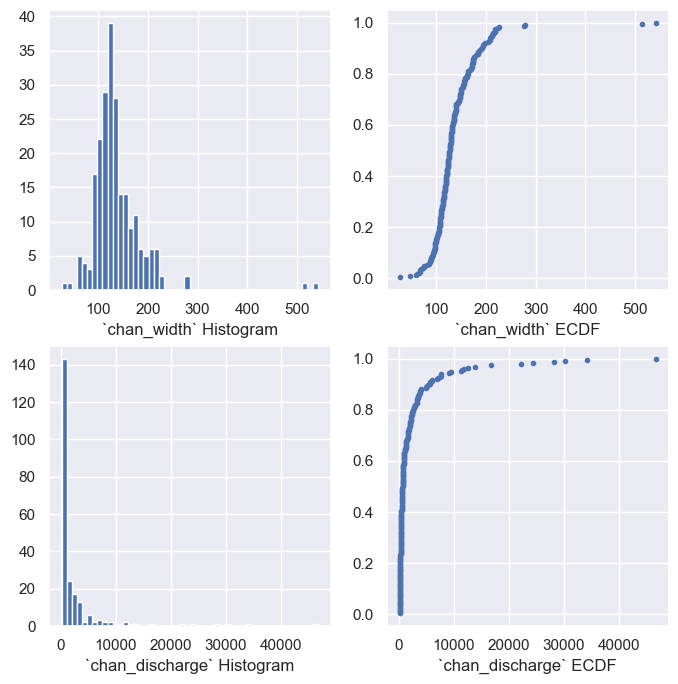

In [75]:
site_no='03599500'
site = site_extraction(site_no, save_csv=False)
stat_plot(site, site_no, 'chan_width', save_png=True)

## Channel Width

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 62.60it/s]


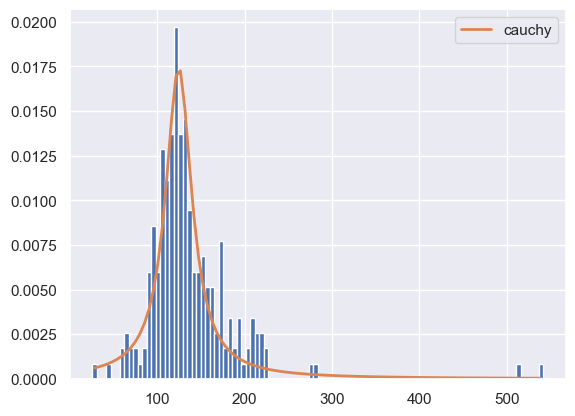

In [29]:
f1 = Fitter(site["chan_width"].values, distributions= ['cauchy'])
f1.fit()
f1.summary()
marginal_params1 = f1.get_best(method = "sumsquare_error")
marginal_cdf1 = ss.cauchy.cdf(site["chan_width"].values, loc=marginal_params1['cauchy']['loc'], scale=marginal_params1['cauchy']['scale'])

## Channel Discharge

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 22.26it/s]


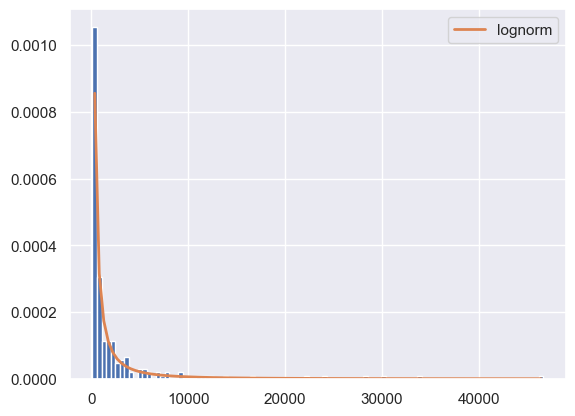

In [43]:
f2 = Fitter(site["chan_discharge"].values, distributions= ['lognorm'])
f2.fit()
f2.summary()
marginal_params2 = f2.get_best(method = "sumsquare_error")
marginal_cdf2 = ss.lognorm.cdf(site["chan_discharge"].values, s=marginal_params2['lognorm']['s'], loc=marginal_params2['lognorm']['loc'], scale=marginal_params2['lognorm']['scale'])

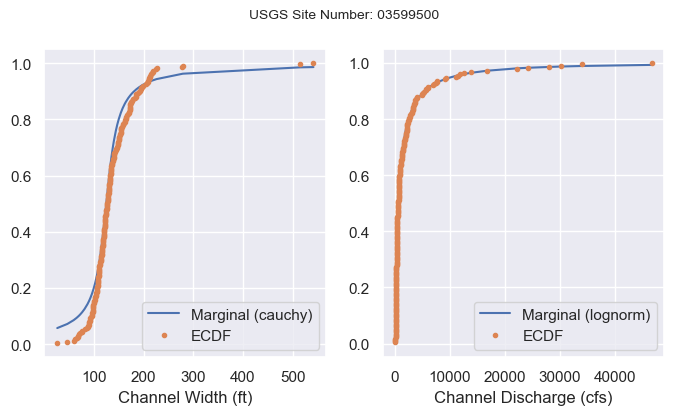

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

ax1.plot(site["chan_width"].sort_values(), np.sort(marginal_cdf1),  label='Marginal (cauchy)')

y = np.arange(1, len(site["chan_width"])+1) / len(site["chan_width"])
ax1.plot(site["chan_width"].sort_values(), y, linestyle='none', marker='.', label='ECDF')
ax1.legend()
ax1.set_xlabel('Channel Width (ft)')

ax2.plot(site["chan_discharge"].sort_values(), np.sort(marginal_cdf2), label='Marginal (lognorm)')

y = np.arange(1, len(site["chan_discharge"])+1) / len(site["chan_discharge"])
ax2.plot(site["chan_discharge"].sort_values(), y, linestyle='none', marker='.', label='ECDF')
ax2.legend()
ax2.set_xlabel('Channel Discharge (cfs)')

plt.suptitle(f'USGS Site Number: {site_no}', size=10)
fig.savefig(f'tauraat/data/{site_no}_ecdf_vs_marginal.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Joint probability distribution

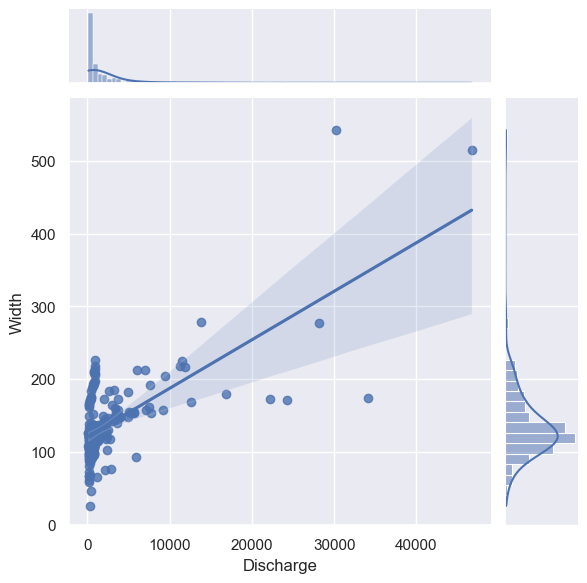

In [76]:
h = sns.jointplot(x=site["chan_discharge"], y=site["chan_width"], kind="reg")
_ = h.set_axis_labels("Discharge", "Width", fontsize=12)

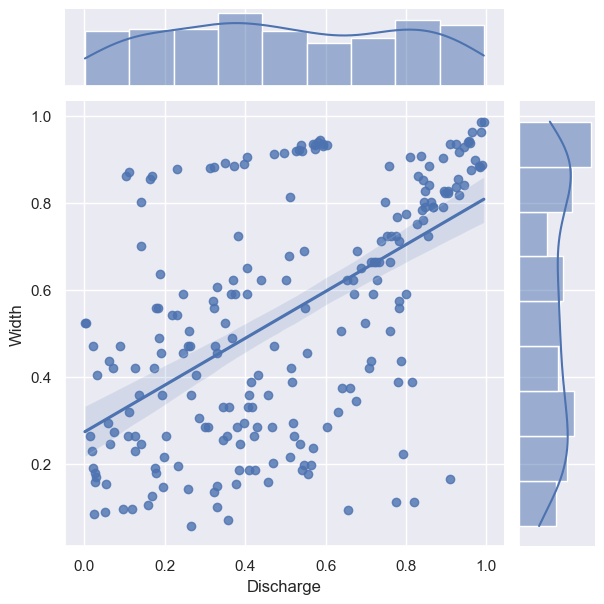

In [77]:
h = sns.jointplot(x=marginal_cdf2, y=marginal_cdf1, kind="reg")
_ = h.set_axis_labels("Discharge", "Width", fontsize=12)